# Import Libraries

In [4]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)

# New Imports
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
    (LinearDiscriminantAnalysis as LDA, 
     QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Exploration

## Description:
This dataset consists of percentage returns for the S&P 500 stock index over 1250 days, from the beginning of 2001 until the end of 2005.

## Features:
`Lag1` to `Lag5`: Percentage returns for each of the five previous trading days

`Volume`: The number of shares traded on th previous day, in billions

`Today`: The percentage return on the date in question

`Direction`: Whether the market was `Up` or `Down`

In [6]:
Smarket = load_data("Smarket")
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


## Identify pair-wise correlation among predictors

Ignore `Direction` because it is a qualitative predictor

In [12]:
Smarket.iloc[:, :-1].corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


## From the data, we can see that the volume is increasing over time. In other words, the average number of shares increased over time 

<Axes: >

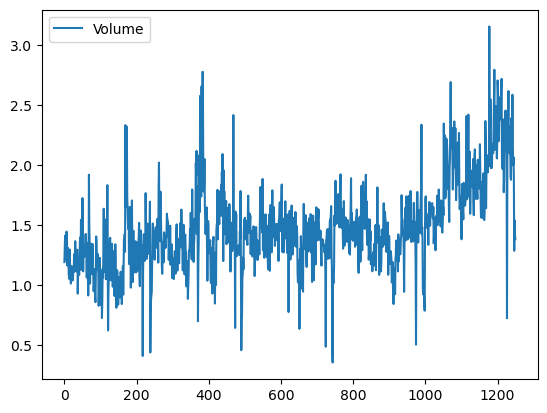

In [13]:
Smarket.plot(y="Volume")

# Logistic Regression

Fit a logistic regression model to predict `Direction` using `Lag1` through `Lag5` and `Volume`.

In [14]:
allvars = Smarket.columns.drop(["Today", "Direction", "Year"])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == "Up"

glm = sm.GLM(
    y, 
    X,
    family = sm.families.Binomial() 
)
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


The predictor with the smallest p-value is `Lag1`. The negative coefficient for this predictor suggests that if the market had a positive return yesterday, then it is likely to go up today. However, at a p-value of 0.15, it is still relatively large, and so there is no clear association between `Lag1` and `Direction`.

## See coefficient estimates for each predictor

In [15]:
results.params

intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

## See p-value of coefficient estimates for each predictor

In [16]:
results.pvalues

intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

## Probabilties of the market going up for the first 10 observations

In [17]:
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

## Confusion table to check prediction results

In [22]:
labels = np.array(["Down"] * 1250)
labels[probs>0.5] = "Up"

confusion_table(labels, Smarket["Direction"])

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


From the confusion table, we can see that the model correctly predicted 507 + 145 = 652 observations, which meant that the logistic regression correctly predicted the movement of the market 52.2% of the time. This would make 47.8% the training error rate.

But the training error rate is often overly-optimistic so we will only know whether the Logistic Regression model is performing better than random guessing (50%) if we test the same model on the test data.

To create the test data, we can use the data we already have and withhold part of the data for testing, and use the remaining data for training.

In [23]:
(507+145)/1250, np.mean(labels==Smarket["Direction"])

(0.5216, 0.5216)

## Test model on test data

### Create test data

Create a Boolean vector corresponding to the observations from 2001 through 2004. We then use this vector to create a held out data set of observations from 2005.

In [26]:
train = (Smarket["Year"] < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

(252, 9)

### Train using a subset of the original data

In [27]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

glm_train = sm.GLM(
    y_train,
    X_train,
    family=sm.families.Binomial()
)
results = glm_train.fit()
probs = results.predict(exog=X_test)

### Compare predictions between true and predicted

Set threshold = 50%

In [28]:
D = Smarket["Direction"]
L_train, L_test = D.loc[train], D.loc[~train]

From the confusion matrix, we can see that the test accuracy is about 48% while the error rate is about 52%, which is higher than the error rate we got when we tested it on the original data.

In [29]:
labels = np.array(["Down"] * 252)
labels[probs > 0.5] = "Up"
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [30]:
np.mean(labels == L_test), np.mean(labels != L_test)

(0.4801587301587302, 0.5198412698412699)

## Refit model with only Lag1 and Lag2 (lowest p-values)

The cause for the poor performance of the previous model might be the result of redundant predictors which increases the variance of model without a corresponding decrease in bias.

### Confusion matrix

In [31]:
model = MS(["Lag1", "Lag2"]).fit(Smarket)
X=model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(
    y_train,
    X_train,
    family=sm.families.Binomial()
)
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(["Down"]*252)
labels[probs>0.5] = "Up"
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


### Accuracy of revised model

The model improved to 56%, but this is no better than the naive approach of predicting that the market will increase everyday (Null Classifier). Hence, in terms of overall error rate, the logistic regression model did not perform that well.

However, when the model predicts an increase in the market, it has a 58% accuracy rate. This suggests a possible trading strategy of buying on days when the model predicts an increasing market, and avoid trades on days when a decrease is predicted.

In [33]:
(35+106)/252, 106/(106+76)

(0.5595238095238095, 0.5824175824175825)

In [35]:
(106+35) / (106+35+35+76)

0.5595238095238095

## Prediction with specific values of X

In [36]:
newdata = pd.DataFrame(
    {
        "Lag1": [1.2, 1.5],
        "Lag2": [1.1, -0.8]
    }
)
newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

# Linear Discriminant Analysis (LDA)

Do the same but this time with LDA

LDA estimator automatically adds an intercept, so we do not need to add an intercept into our design matrix

In [38]:
lda = LDA(store_covariance=True)

In [40]:
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

### Extract means in the two classes

The values below show the average of each predictor within each class, and are used by LDA as estimates of $\mu_k$.

This suggest that there is a tendency for the previous 2 days' returns to be negative on days when the market increases, and a tendency for the previous days' returns to be positive on days when the market declines.

In [41]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

### Extract prior probabilities

`sklearn` typically uses trailing _ to denote a quantity estimated when using the `fit()` method.

In [42]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

$\hat{\pi}_{Down}$ = 0.492, $\hat{\pi}_{Up}$ = 0.508

In [43]:
lda.priors_

array([0.49198397, 0.50801603])

### Extract linear discriminant vectors

These values provide the linear combination of `Lag1` and `Lag2` that are used to form the LDA decision rule. In other words, if 

$$\begin{align}
-0.64 \times Lag1 - 0.51 \times Lag2
\end{align}$$

is large, then the LDA classifier will predict a market increase, and if it is small, then the LDA classifier will predict a market decline.

In [44]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

## Confusion matrix for LDA model

This shows the accuracy is similar to the logistic regression model.

## Side note:
sklearn's ML design choice is as such: first instantiate the classifier, followed by fitting it `fit()`, and then producing predictions `predict()`.

In [46]:
lda_pred = lda.predict(X_test)
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [47]:
lda.predict_proba(X_test)

array([[0.49017925, 0.50982075],
       [0.4792185 , 0.5207815 ],
       [0.46681848, 0.53318152],
       [0.47400107, 0.52599893],
       [0.49278766, 0.50721234],
       [0.49385615, 0.50614385],
       [0.49510156, 0.50489844],
       [0.4872861 , 0.5127139 ],
       [0.49070135, 0.50929865],
       [0.48440262, 0.51559738],
       [0.49069628, 0.50930372],
       [0.51199885, 0.48800115],
       [0.48951523, 0.51048477],
       [0.47067612, 0.52932388],
       [0.47445929, 0.52554071],
       [0.47995834, 0.52004166],
       [0.49357753, 0.50642247],
       [0.50308938, 0.49691062],
       [0.49788061, 0.50211939],
       [0.48863309, 0.51136691],
       [0.50065681, 0.49934319],
       [0.51087353, 0.48912647],
       [0.50399248, 0.49600752],
       [0.49163351, 0.50836649],
       [0.50417721, 0.49582279],
       [0.50267505, 0.49732495],
       [0.49140429, 0.50859571],
       [0.48059641, 0.51940359],
       [0.48827181, 0.51172819],
       [0.50621869, 0.49378131],
       [0.

# Quadratic Discriminant Analysis (QDA)

In [48]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [49]:
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

## Estimated covariance in the first class

In [50]:
qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

## QDA does not have the `scaling_` attribute because it models the relationship between predictors and the response using quadratic functions instead of linear functions.

## Interestingly, the QDA predictions are accurate almost 60% of the time, even though the 2005 data was not used to fit the model.

This suggests that the quadratic form assumed by QDA may capture the true relationship more accurately than the linear forms assumed by LDA and Logistic regression.

In [51]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [53]:
np.mean(qda_pred==L_test)

0.5992063492063492

# Naive Bayes

In [54]:
NB = GaussianNB()
NB.fit(X_train, L_train)

GaussianNB()

In [55]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [56]:
NB.class_prior_

array([0.49198397, 0.50801603])

## The parameters of the features

In [57]:
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

## The variance of the features

In [58]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

## Mean computation

In [61]:
X_train[L_train == "Down"].mean()

Lag1    0.042790
Lag2    0.033894
dtype: float64

## Variance computation

In [62]:
X_train[L_train == "Down"].var(ddof=0)

Lag1    1.503554
Lag2    1.532467
dtype: float64

## Confusion matrix

Naive Bayes perform well on these data, with accurate predictions over 59% of the time. This is slightly worse than QDA, but much better than LDA.

In [64]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


## Estimate the probability for each observation

In [65]:
NB.predict_proba(X_test)[:5]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

# K-Nearest Neighbour

The results using K=1 are not very good. 

In [66]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


In [67]:
np.mean(knn1_pred == L_test)

0.5

results improve slightly when k = 3. 

In [69]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3_pred = knn3.fit(X_train, L_train).predict(X_test)
np.mean(knn3_pred==L_test)

0.5317460317460317

# Using KNN on a different dataset

The `Caravan` dataset includes 85 predictors that measure demographic characteristics for 5,822 individuals. The response variable is `Purchase`, which indicates whether or not a given individual purchases a caravan insurance policy. 

In this data set, only 6% of people purchased caravan insurance.

In [70]:
Caravan = load_data("Caravan")
Purchase = Caravan["Purchase"]
Purchase.value_counts()

Purchase
No     5474
Yes     348
Name: count, dtype: int64

In [71]:
348 / 5822

0.05977327378907592

Features will include all columns except `Purchase`

In [72]:
feature_df = Caravan.drop(columns=["Purchase"])

A problem arises when using KNN: scaling of the data. Because the KNN classifier predicts the class of a given test observation by identifying the observations that are nearest to it, the scale of the variables matters. Any variables that are on a large scale will have a much larger effect on the distance between the observations, and hence on the KNN classifier, than variables that are on a small scale.

For example, in an arbitrary dataset with two predictors `salary` and `age` (measured in dollars and years respectively.) As far as KNN is concerned, a difference of 1,000 USD in salary is enormouse compared to a difference of 50 years in age. Consequently, `salary` will drive the KNN classification results, and `age` will have almost no effect. This is contrary to our intuition that a salary difference of 1,000 USD is quite small compared to an age difference of 50 years. Furthermore, the importance of scale to the KNN classifier leads to another issue: if we measured `salary` in Japanese yen, or if we measured `age` in minutes, then we'd get quite different classication results from what we get if these two variables are measured in dollars and years.

A good way to handle this problem is to standardise the data so that all variables are given a mean of zero and a standard deviation of one. Then all variables will be on a comparable scale.

In the first line below, the parameters for the scaling are computed and stored in `scaler`, while the second line actually constructs the standardised set of features.

Now every column of `feature_std` below has a standard deviation of one and a mean of zero

In [73]:
scaler = StandardScaler(
    with_mean=True,
    with_std=True,
    copy=True
    )

scaler.fit(feature_df)
X_std = scaler.transform(feature_df)

In [75]:
X_std

array([[ 0.68090623, -0.27257995,  0.40669664, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [ 0.99229684, -0.27257995, -0.85950007, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [ 0.99229684, -0.27257995, -0.85950007, ..., -0.15062046,
        -0.08734772, -0.11881647],
       ...,
       [ 0.68090623, -0.27257995,  0.40669664, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [ 0.75875388, -0.27257995,  0.40669664, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [ 0.68090623, -0.27257995,  0.40669664, ..., -0.15062046,
        -0.08734772, -0.11881647]])

The reason the standard deviation is not exactly one is because the computation of standard deviation uses n-1 degrees of freedom.

In [82]:
feature_std = pd.DataFrame(
    X_std,
    columns=feature_df.columns
)
feature_std.std()

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

Using the function `train_test_split()` we now split the observations into a test set, containing 100 observations, and a training set containing the remaining observations. The argument `random_state=0` ensures that we get the same split each time we rerun the code.

In [84]:
(
    X_train,
    X_test,
    y_train,
    y_test
) = train_test_split(feature_std, Purchase, test_size=1000, random_state=0)

Now we fit a KNN model on the training data using K=1, and evaluate its performance on the test data.

The KNN error rate on the 1000 test observations is about 11%. At first glance, this may appear to be fairly good. However, since just over 6% of customers purchased insurance, we could get the error rate down to almost 6% by always producing `No` regardless of the values of the predictors! This is known as the null rate.

In [87]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train, y_train).predict(X_test)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")

(0.111, 0.067)

In the context of insurance, if there is a non-trivial cost associated with selling insurance to a given individual (i.e. travelling to the individual), a company might be more interested in the fraction of individuals that are correctly predicted to buy insurance. Hence, the overall error rate is not a concern.

In [88]:
confusion_table(knn1_pred, y_test)

Truth,No,Yes
Predicted,,
No,880,58
Yes,53,9


It turns out that KNN with K=1 does far better than random guessing among the customers that are predicted to buy insurance. Among 62 such customers 14.5% actually do purchase insurance.

In [89]:
9/(53+9)

0.14516129032258066

## Tuning Parameters

The number of neighbours in KNN is referred to as a tuning parameter, also referred to as a hyperparameter.

In [90]:
for K in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    C = confusion_table(knn_pred, y_test)
    templ = ("K={0:d}: # predicted to rent: {1:>2}," +
             "  # who did rent {2:d}, accuracy {3:.1%}")
    pred = C.loc["Yes"].sum()
    did_rent = C.loc["Yes", "Yes"]
    print(templ.format(K, pred, did_rent, did_rent / pred))

K=1: # predicted to rent: 62,  # who did rent 9, accuracy 14.5%
K=2: # predicted to rent:  6,  # who did rent 1, accuracy 16.7%
K=3: # predicted to rent: 20,  # who did rent 3, accuracy 15.0%
K=4: # predicted to rent:  4,  # who did rent 0, accuracy 0.0%
K=5: # predicted to rent:  7,  # who did rent 1, accuracy 14.3%


## Comparison to Logistic Regression

This can be done with `sklearn`, though by default it fits something like the ridge regression version of logistic regression. This can be modified by appropriately setting the argument `C` below. Its default value is 1 but by setting it to a very large number, the algorithm converges to the same solution as the usual (unregularised) logistic regression estimator.

In [91]:
logit = LogisticRegression(C=1e10, solver="liblinear")
logit.fit(X_train, y_train)
logit_pred = logit.predict_proba(X_test)
logit_labels = np.where(logit_pred[:,1] > 5, "Yes", "No")
confusion_table(logit_labels, y_test)

Truth,No,Yes
Predicted,,
No,933,67
Yes,0,0


In [92]:
logit_labels = np.where(logit_pred[:,1]>0.25, "Yes", "No")
confusion_table(logit_labels, y_test)

Truth,No,Yes
Predicted,,
No,913,58
Yes,20,9


In [93]:
9/(20+9)

0.3103448275862069

# Linear and Poisson Regression on the Bikeshare data

In [94]:
Bike = load_data("Bikeshare")

In [95]:
Bike.shape, Bike.columns

((8645, 15),
 Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
        'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
        'registered', 'bikers'],
       dtype='object'))

## Linear Regression

In [96]:
X = MS(["mnth",
        "hr",
        "workingday",
        "temp",
        "weathersit"]).fit_transform(Bike)
Y = Bike["bikers"]
M_lm = sm.OLS(Y, X).fit()
summarize(M_lm)

,coef,std err,t,P>|t|
intercept,-68.6317,5.307,-12.932,0.000
mnth[Feb],6.8452,4.287,1.597,0.110
mnth[March],16.5514,4.301,3.848,0.000
mnth[April],41.4249,4.972,8.331,0.000
mnth[May],72.5571,5.641,12.862,0.000
mnth[June],67.8187,6.544,10.364,0.000
mnth[July],45.3245,7.081,6.401,0.000
mnth[Aug],53.2430,6.640,8.019,0.000
mnth[Sept],66.6783,5.925,11.254,0.000
mnth[Oct],75.8343,4.950,15.319,0.000


In [97]:
hr_encode = contrast("hr", "sum")
mnth_encode = contrast("mnth", "sum")

In [98]:
X2 = MS([mnth_encode, 
         hr_encode,
         "workingday",
         "temp",
         "weathersit"]).fit_transform(Bike)
M2_lm = sm.OLS(Y, X2).fit()
S2 = summarize(M2_lm)
S2

,coef,std err,t,P>|t|
intercept,73.5974,5.132,14.340,0.000
mnth[Jan],-46.0871,4.085,-11.281,0.000
mnth[Feb],-39.2419,3.539,-11.088,0.000
mnth[March],-29.5357,3.155,-9.361,0.000
mnth[April],-4.6622,2.741,-1.701,0.089
mnth[May],26.4700,2.851,9.285,0.000
mnth[June],21.7317,3.465,6.272,0.000
mnth[July],-0.7626,3.908,-0.195,0.845
mnth[Aug],7.1560,3.535,2.024,0.043
mnth[Sept],20.5912,3.046,6.761,0.000


In [99]:
np.sum((M_lm.fittedvalues - M2_lm.fittedvalues)**2)

1.0341283435713732e-18

In [100]:
np.allclose(M_lm.fittedvalues, M2_lm.fittedvalues)

True

In [101]:
coef_month = S2[S2.index.str.contains('mnth')]['coef'] 
coef_month

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
Name: coef, dtype: float64

In [103]:
months = Bike["mnth"].dtype.categories
coef_month = pd.concat([
    coef_month, 
    pd.Series([-coef_month.sum()],
              index=["mnth[Dec]"])
])
coef_month

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
mnth[Dec]       0.3705
mnth[Dec]      -0.0000
dtype: float64

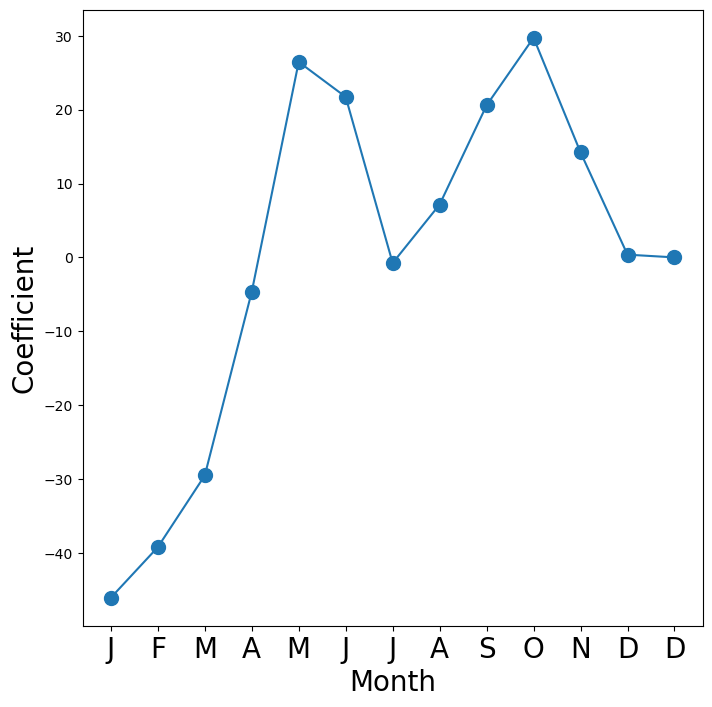

In [105]:
fig_month, ax_month = subplots(figsize=(8,8))
x_month = np.arange(coef_month.shape[0])
ax_month.plot(x_month, coef_month, marker='o', ms=10) 
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize
=20)
ax_month.set_xlabel('Month', fontsize=20) 
ax_month.set_ylabel('Coefficient', fontsize=20);

In [106]:
coef_hr = S2[S2.index.str.contains('hr')]['coef']
coef_hr = coef_hr.reindex(['hr[{0}]'.format(h) for h in range(23)]) 
coef_hr = pd.concat([coef_hr, pd.Series([-coef_hr.sum()], index=['hr[23]']) ])

Text(0, 0.5, 'Coefficient')

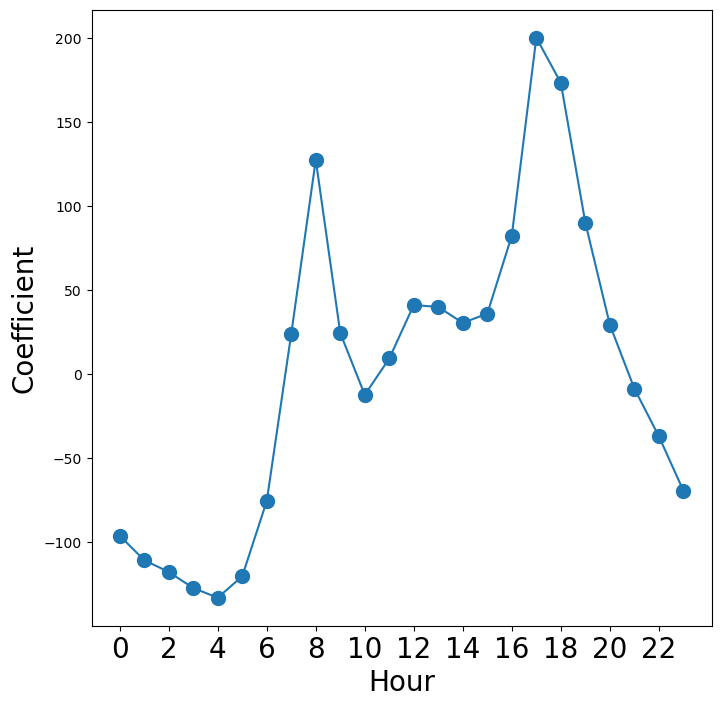

In [109]:
fig_hr, ax_hr = subplots(figsize=(8,8))
x_hr = np.arange(coef_hr.shape[0]) 
ax_hr.plot(x_hr, coef_hr, marker='o', ms=10)
ax_hr.set_xticks(x_hr[::2])
ax_hr.set_xticklabels(range(24)[::2], fontsize=20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20)


## Poisson Regression

In [110]:
M_pois = sm.GLM(Y, X2, family=sm.families.Poisson()).fit()

In [112]:
S_pois = summarize(M_pois)
coef_month = S_pois[S_pois.index.str.contains('mnth')]['coef'] 
coef_month = pd.concat([coef_month,
pd.Series([-coef_month.sum()], index=['mnth[Dec]'])]) 
coef_hr = S_pois[S_pois.index.str.contains('hr')]['coef']
coef_hr = pd.concat([coef_hr, pd.Series([-coef_hr.sum()],
index=['hr[23]'])])